In [94]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from scrapData import GetHouseList
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.feature_selection import f_regression,SelectKBest
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder
from sklearn import linear_model,ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.decomposition import PCA,TruncatedSVD
from scipy.stats import pearsonr
np.random.seed(123)

# Loading Data

In [2]:
df=pd.read_csv('Data/olx_data_all.csv')
df.head()

,Amenities,Bedrooms,Bathrooms,Area (m²),Furnished,Level,Ad Type,Type,Payment Option,price,title,location,Compound
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,For Sale,Apartment,Cash,"1,600,000 EGP",مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...,Madinaty,Madinaty
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,For Sale,Apartment,Cash,"355,000 EGPnegotiable",شقة بسعر التكلفة في الحي المتميز مدينة بدر...,Badr City,El Ashgar District
2,NaN,3,3,180,No,Ground,For Sale,Apartment,Cash,"3,100,000 EGP",فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...,Rehab City,NaN
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,For Sale,Apartment,Cash,"1,150,000 EGP",شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...,Madinaty,Madinaty
4,"Balcony,Electricity Meter",2,1,80,No,6,For Sale,Apartment,Cash,"185,000 EGP",شقة تشطيب فاخر للبيع,Marg,NaN


# Data Cleaning

In [3]:
df.shape

(26500, 13)

In [4]:
# remove measure unit of price(EGP)
df['price']=df['price'].apply(lambda x: x.replace('EGP','').replace(',','').replace('negotiable','').strip())
df.head()

,Amenities,Bedrooms,Bathrooms,Area (m²),Furnished,Level,Ad Type,Type,Payment Option,price,title,location,Compound
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,For Sale,Apartment,Cash,1600000,مدينتي ١٣٥م بال B1 بحري قريبه جدا من الخدم...,Madinaty,Madinaty
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,For Sale,Apartment,Cash,355000,شقة بسعر التكلفة في الحي المتميز مدينة بدر...,Badr City,El Ashgar District
2,NaN,3,3,180,No,Ground,For Sale,Apartment,Cash,3100000,فرررصة برحاب ٢ للبيع شقة ١٨٠م ارضي بحديقة ...,Rehab City,NaN
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,For Sale,Apartment,Cash,1150000,شقة بمدينتي بال B1 نموذج 100 اقل من سعر ال...,Madinaty,Madinaty
4,"Balcony,Electricity Meter",2,1,80,No,6,For Sale,Apartment,Cash,185000,شقة تشطيب فاخر للبيع,Marg,NaN


In [5]:
df['Payment Option'].unique()

array(['Cash'], dtype=object)

In [6]:
# remove property type where all properties are Apartments
df.drop(['Type','Ad Type','Payment Option','title'],axis=1,inplace=True)
df.columns

Index(['Amenities', 'Bedrooms', 'Bathrooms', 'Area (m²)', 'Furnished', 'Level',
       'price', 'location', 'Compound'],
      dtype='object')

In [7]:
#rename Area (m²) to Area 
df.rename(columns={'Area (m²)':'Area'},inplace=True)

In [8]:
#check null values
df.isna().sum()

Amenities     7636
Bedrooms         0
Bathrooms        0
Area             0
Furnished     5023
Level            5
price            0
location         0
Compound     18912
dtype: int64

In [9]:
# fill aminities NaN with No
df.Amenities.fillna('No',inplace=True)
df.Furnished.fillna('No',inplace=True)
df.Compound.fillna('No',inplace=True)
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,price,location,Compound
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,1600000,Madinaty,Madinaty
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,355000,Badr City,El Ashgar District
2,No,3,3,180,No,Ground,3100000,Rehab City,No
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,1150000,Madinaty,Madinaty
4,"Balcony,Electricity Meter",2,1,80,No,6,185000,Marg,No


In [10]:
df.Furnished.value_counts()

No     24693
Yes     1807
Name: Furnished, dtype: int64

In [11]:
#check level values
print(df.Level.unique(),pd.isnull( df.Level).sum(),df.Level.mode()[0])

['5' '2' 'Ground' '6' '4' '3' '1' '8' '10+' '9' '7' 'Highest' '10' nan] 5 2


In [12]:
df.Level.replace('Ground','0',inplace=True)
df.Level.replace('10+','10',inplace=True)
df.Level.replace('Highest','11',inplace=True)
df.Level.fillna(str(df.Level.mode()[0]),inplace=True)
df.Level.unique()

array(['5', '2', '0', '6', '4', '3', '1', '8', '10', '9', '7', '11'],
      dtype=object)

In [13]:
df.isna().sum()

Amenities    0
Bedrooms     0
Bathrooms    0
Area         0
Furnished    0
Level        0
price        0
location     0
Compound     0
dtype: int64

In [14]:
# check all values of Bedrooms columns
df.Bedrooms.unique()

array(['3', '2', '4', '8', '1', '5', '6', '7', '9', '10', '10+'],
      dtype=object)

In [15]:
df.Bedrooms.replace('10+','10',inplace=True)
df.Bedrooms.unique()

array(['3', '2', '4', '8', '1', '5', '6', '7', '9', '10'], dtype=object)

In [16]:
# check all values of Bedrooms columns
df.Bathrooms.unique()

array(['2', '3', '1', '4', '5', '7', '8', '6', '10+', '10', '9'],
      dtype=object)

In [17]:
df.Bathrooms.replace('10+','10',inplace=True)
df.Bathrooms.unique()

array(['2', '3', '1', '4', '5', '7', '8', '6', '10', '9'], dtype=object)

In [18]:
df.Area=df.Area.apply(lambda x: x.replace(',',''))
df.Area.unique()

array(['135', '140', '180', '107', '80', '70', '85', '130', '100', '120',
       '90', '82', '177', '207', '86', '175', '211', '215', '220', '65',
       '114', '115', '204', '96', '150', '165', '103', '210', '110',
       '266', '240', '300', '200', '170', '230', '182', '146', '153',
       '125', '75', '138', '166', '225', '750', '145', '163', '122',
       '131', '155', '60', '154', '156', '223', '224', '205', '83', '185',
       '133', '250', '190', '178', '105', '108', '164', '196', '124',
       '162', '217', '160', '260', '137', '92', '209', '152', '157',
       '191', '139', '116', '62', '335', '171', '76', '202', '278', '320',
       '186', '127', '123', '350', '38', '265', '199', '117', '255', '77',
       '226', '64', '241', '73', '132', '400', '134', '113', '158', '118',
       '72', '67', '201', '136', '88', '245', '270', '10', '63', '195',
       '192', '168', '360', '161', '91', '272', '167', '126', '99', '290',
       '176', '594', '187', '148', '128', '143', '251', '20

In [19]:
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,price,location,Compound
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,1600000,Madinaty,Madinaty
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,355000,Badr City,El Ashgar District
2,No,3,3,180,No,0,3100000,Rehab City,No
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,1150000,Madinaty,Madinaty
4,"Balcony,Electricity Meter",2,1,80,No,6,185000,Marg,No


In [20]:
# reorder columns
df=df.loc[:,['Amenities','Bedrooms','Bathrooms','Area','Furnished','Level','location','Compound','price']]
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,location,Compound,price
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135,No,5,Madinaty,Madinaty,1600000
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140,No,2,Badr City,El Ashgar District,355000
2,No,3,3,180,No,0,Rehab City,No,3100000
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107,No,6,Madinaty,Madinaty,1150000
4,"Balcony,Electricity Meter",2,1,80,No,6,Marg,No,185000


In [21]:
# convert funished category
df.Furnished=df.Furnished.replace({'No':0,'Yes':1})

In [22]:
# check data types
df.dtypes

Amenities    object
Bedrooms     object
Bathrooms    object
Area         object
Furnished     int64
Level        object
location     object
Compound     object
price        object
dtype: object

In [23]:
# change bedrooms, bathrooms and area into integers, and price into float
df.Bedrooms=df.Bedrooms.astype(int)
df.Bathrooms=df.Bathrooms.astype(int)
df.Area=df.Area.astype(float)
df.Level=df.Level.astype(int)
df.price=df.price.astype(float)
df.dtypes

Amenities     object
Bedrooms       int32
Bathrooms      int32
Area         float64
Furnished      int64
Level          int32
location      object
Compound      object
price        float64
dtype: object

In [24]:
df.head()

,Amenities,Bedrooms,Bathrooms,Area,Furnished,Level,location,Compound,price
0,"Balcony,Security,Covered Parking,Electricity M...",3,2,135.0,0,5,Madinaty,Madinaty,1600000.0
1,"Balcony,Pets Allowed,Private Garden,Security,E...",3,2,140.0,0,2,Badr City,El Ashgar District,355000.0
2,No,3,3,180.0,0,0,Rehab City,No,3100000.0
3,"Balcony,Pets Allowed,Security,Electricity Mete...",2,1,107.0,0,6,Madinaty,Madinaty,1150000.0
4,"Balcony,Electricity Meter",2,1,80.0,0,6,Marg,No,185000.0


# Explaratory data analysis

In [25]:
#check correllation of feature with the predicted variable (price)
df[['Bedrooms','Bathrooms','Area','Level','Furnished','price']].corr()

,Bedrooms,Bathrooms,Area,Level,Furnished,price
Bedrooms,1.000000,0.505807,-0.004710,0.042594,-0.003458,0.276485
Bathrooms,0.505807,1.000000,-0.002722,-0.080361,-0.006971,0.365814
Area,-0.004710,-0.002722,1.000000,-0.001136,-0.000612,-0.003480
Level,0.042594,-0.080361,-0.001136,1.000000,0.038617,-0.065321
Furnished,-0.003458,-0.006971,-0.000612,0.038617,1.000000,0.100371
price,0.276485,0.365814,-0.003480,-0.065321,0.100371,1.000000


it seems that all correlation is weak

#### >> Price

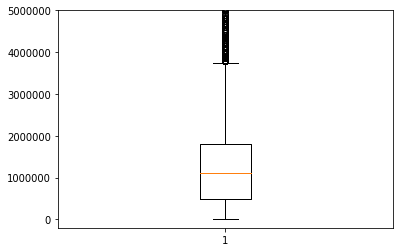

In [26]:
plt.boxplot(df.price)
plt.ylim(-200000,5000000)
plt.show()

In [27]:
#check price stats
median = np.median(df.price)
upper_quartile = np.percentile(df.price, 75)
lower_quartile = np.percentile(df.price, 25)
iqr = upper_quartile - lower_quartile
upper_whisker = df.price[df.price<=upper_quartile+1.5*iqr].max()
lower_whisker = df.price[df.price>=lower_quartile-1.5*iqr].min()
print("median: {} , Q3: {}, Q1: {},upper_whisker: {} ,lower_whisker: {}".format(median,upper_quartile,lower_quartile,upper_whisker,lower_whisker))

median: 1100000.0 , Q3: 1800000.0, Q1: 500000.0,upper_whisker: 3750000.0 ,lower_whisker: 800.0


In [28]:
# check number of outliers in price
df[df.price>3600068].shape

(1147, 9)

In [29]:
# remove price outliers
df=df[df.price<3600068]

#### Enhancing correlation

#### >>Area

(-20, 500)

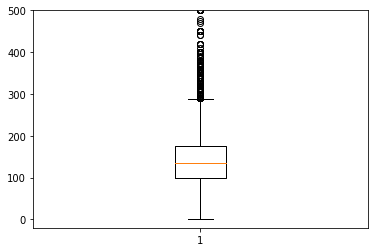

In [30]:
plt.boxplot(df.Area)
plt.ylim(-20,500)

In [31]:
median = np.median(df.Area)
upper_quartile = np.percentile(df.Area, 75)
lower_quartile = np.percentile(df.Area, 25)

iqr = upper_quartile - lower_quartile
upper_whisker = df.Area[df.Area<=upper_quartile+1.5*iqr].max()
lower_whisker = df.Area[df.Area>=lower_quartile-1.5*iqr].min()
print("median: {} , Q3: {}, Q1: {},upper_whisker: {} ,lower_whisker: {}".format(median,upper_quartile,lower_quartile,upper_whisker,lower_whisker))

median: 135.0 , Q3: 175.0, Q1: 100.0,upper_whisker: 287.0 ,lower_whisker: 0.0


In [32]:
df[df.Area>295].shape

(418, 9)

In [33]:
# remove Area outliers
df=df[df.Area<295]

In [34]:
# check corr
df[['Area','price']].corr()

,Area,price
Area,1.000000,0.623759
price,0.623759,1.000000


after removing outliers from price and area we increased the area correlation from -0.003480 to 0.623759

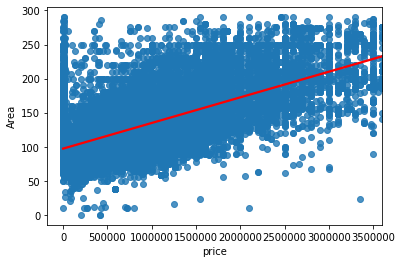

In [35]:
sns.regplot(df.price,df.Area,line_kws = {'color': 'red'})


#### >> Bathroom

{'whiskers': [<matplotlib.lines.Line2D at 0x1492f79ec8>,
 'caps': [<matplotlib.lines.Line2D at 0x1492f7de48>,
 'boxes': [<matplotlib.lines.Line2D at 0x1492f79408>],
 'medians': [<matplotlib.lines.Line2D at 0x1492f7fdc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1492f7fec8>],
 'means': []}

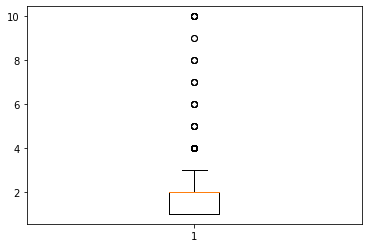

In [36]:
plt.boxplot( df.Bathrooms)

In [37]:
#chek numbers of outliers
df[df.Bathrooms>3].shape

(251, 9)

In [38]:
# remove Bathrooms outliers
df=df[df.Bathrooms<=3]

In [39]:
#check correlation
df[['Bathrooms','price']].corr()

,Bathrooms,price
Bathrooms,1.000000,0.639126
price,0.639126,1.000000


after removing outliers from bathroom we icreased the correlation from 0.365814 to 0.504977

#### >> Bedrooms

{'whiskers': [<matplotlib.lines.Line2D at 0x14930b3d08>,
 'caps': [<matplotlib.lines.Line2D at 0x14930b8cc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x14930b3348>],
 'medians': [<matplotlib.lines.Line2D at 0x14930bcc48>],
 'fliers': [<matplotlib.lines.Line2D at 0x14930bcd48>],
 'means': []}

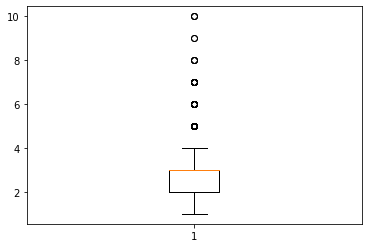

In [40]:
#check data distribution
plt.boxplot(df.Bedrooms)

In [41]:
#check price stats
median = np.median(df.Bedrooms)
upper_quartile = np.percentile(df.Bedrooms, 75)
lower_quartile = np.percentile(df.Bedrooms, 25)
iqr = upper_quartile - lower_quartile
upper_whisker = df.Bedrooms[df.Bedrooms<=upper_quartile+1.5*iqr].max()
lower_whisker = df.Bedrooms[df.Bedrooms>=lower_quartile-1.5*iqr].min()
print("median: {} , Q3: {}, Q1: {},upper_whisker: {} ,lower_whisker: {}".format(median,upper_quartile,lower_quartile,upper_whisker,lower_whisker))

median: 3.0 , Q3: 3.0, Q1: 2.0,upper_whisker: 4 ,lower_whisker: 1


In [42]:
# check shape of outliers
df[df.Bedrooms>4].shape

(135, 9)

In [43]:
# remove outliers of Bedrooms
df=df[df.Bedrooms<=4]

In [44]:
# check correlation
df[['Bedrooms','price']].corr()

,Bedrooms,price
Bedrooms,1.000000,0.339631
price,0.339631,1.000000


after removing outliers from Bedroom we icreased the correlation from 0.276485 to 0.339631

#### >> Level

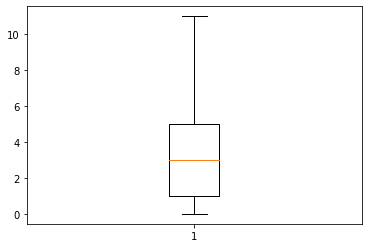

In [45]:
plt.boxplot(df.Level)
plt.show()

In [46]:
df[['Level','price']].corr()

,Level,price
Level,1.000000,-0.156425
price,-0.156425,1.000000


#### >> Furnished

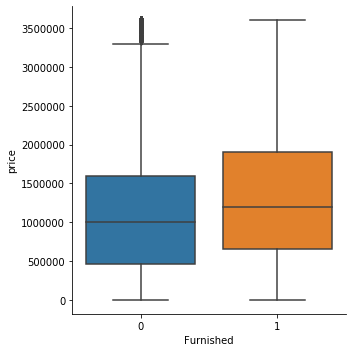

In [47]:
sns.catplot(x="Furnished", y="price", kind="box", data=df)

most of data are overlapped(small variance between data)

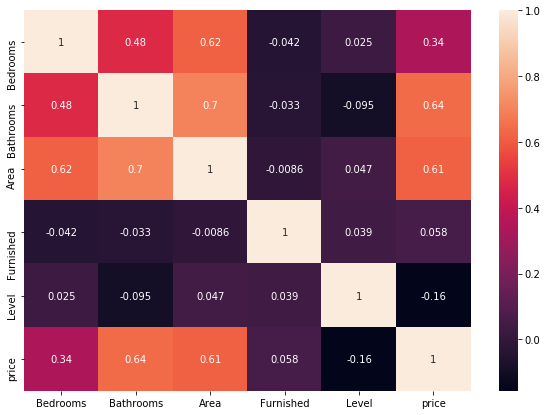

In [48]:
#### check final correlation
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot = True)

# Prediction

In [52]:
df_num=df.iloc[:,[1,2,3,4,5,-1]]
df_num.head()

,Bedrooms,Bathrooms,Area,Furnished,Level,price
0,3,2,135.0,0,5,1600000.0
1,3,2,140.0,0,2,355000.0
2,3,3,180.0,0,0,3100000.0
3,2,1,107.0,0,6,1150000.0
4,2,1,80.0,0,6,185000.0


In [72]:
#split data to train/test
X=df_num.iloc[:,:-1]
Y=df_num.iloc[:,-1]
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=40)
print('training set: ',X_train.shape,y_train.shape)
print('test set: ',X_test.shape,y_test.shape)
X.head(2)

training set:  (19636, 5) (19636,)
test set:  (4909, 5) (4909,)


,Bedrooms,Bathrooms,Area,Furnished,Level
0,3,2,135.0,0,5
1,3,2,140.0,0,2


### 1. Linear Regression

In [90]:
# train the linear regression model
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
y_hat=reg.predict(X_test)
y_hat_train=neigh.predict(X_train)
print('R square:{:0.2f} '.format(r2_score(y_test,y_hat))) 
print('Train R square:{:0.2f} '.format(r2_score(y_train,y_hat_train))) 

R square:0.48 
Train R square:0.64 


In [101]:
# cross validation
scores = cross_val_score(reg, X, Y, cv=100)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.48 (+/- 0.12)


### 2. KNN

In [91]:
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train,y_train.ravel())
y_hat=neigh.predict(X_test)
y_hat_train=neigh.predict(X_train)
print('R square:{:0.2f} '.format(r2_score(y_test,y_hat))) 
print('Train R square:{:0.2f} '.format(r2_score(y_train,y_hat_train))) 

R square:0.55 
Train R square:0.64 


In [102]:
# cross validation
scores = cross_val_score(neigh, X, Y, cv=100)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.58 (+/- 0.13)


### 3. GBoost

In [93]:
acc={}
params = {'n_estimators': 500,#the number of boosting stages
          'max_depth': 6,#limits the number of nodes in the tree
          'min_samples_split': 4,# the minimum number of samples required to split an internal node.
          'learning_rate': 0.01,#how much the contribution of each tree will shrink.
          'loss': 'ls',
          #'booster':'gblinear'
         }#loss function to optimize. The least squares function is used in this case

gBoost_model=ensemble.GradientBoostingRegressor(**params)
gBoost_model.fit(X_train,y_train.ravel())
y_hat=gBoost_model.predict(X_test)
y_hat_train=gBoost_model.predict(X_train)
print('Test R square:{:0.2f} '.format(r2_score(y_test,y_hat))) 
print('Train R square:{:0.2f} '.format(r2_score(y_train,y_hat_train))) 

Test R square:0.57 
Train R square:0.62 


In [103]:
# cross validation
scores = cross_val_score(gBoost_model, X, Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.58 (+/- 0.03)


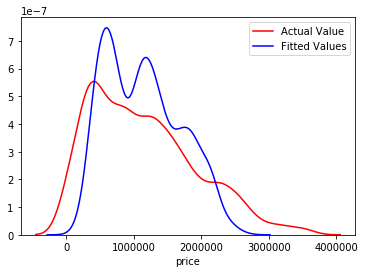

In [74]:
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_hat, hist=False, color="b", label="Fitted Values" , ax=ax1)